In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---ファイルの読み込むパスを指定---
file_path_left_device = "WearableDevices/oba_l_left_foot_data.csv"
file_path_right_device = "WearableDevices/oba_l_right_foot_data.csv"
file_path_mocap = "MotionCaptures/oba_l_mocap.csv"
file_path_force = "3DGroundForces/oba_l_force.csv"

# ---CSVファイルの読み込み---
df_left_device = pd.read_csv(file_path_left_device, header=0)
df_right_device = pd.read_csv(file_path_right_device, header=0)
df_mocap = pd.read_csv(file_path_mocap, header=[2, 5, 6])
df_force = pd.read_csv(file_path_force, header=10, encoding='shift_jis')

In [127]:
"""
# ---モーションキャプチャデータの列名を整理---
"""
new_columns = []

for col in df_mocap.columns:
    # col[0]: Rigid Body 001, col[1]: Position, col[2]: X
    
    # 1. FrameとTimeはそのまま
    if col[2] == 'Frame':
        new_columns.append('Frame')
    elif 'Time' in col[2]:
        new_columns.append('Time (Seconds)')
        
    # 2. それ以外は "Rigid Body " を削除して番号だけにする
    else:
        # "Rigid Body " を空文字に置換し、前後の空白も削除
        body_num = col[0].replace('Rigid Body', '').strip()
        
        # 例: 001_Position_X
        name = f"{body_num}_{col[1]}_{col[2]}"
        new_columns.append(name)

# 列名を更新
df_mocap.columns = new_columns

print(df_mocap.columns)

Index(['Frame', 'Time (Seconds)', '001_Rotation_X', '001_Rotation_Y',
       '001_Rotation_Z', '001_Position_X', '001_Position_Y', '001_Position_Z',
       '002_Rotation_X', '002_Rotation_Y', '002_Rotation_Z', '002_Position_X',
       '002_Position_Y', '002_Position_Z', '003_Rotation_X', '003_Rotation_Y',
       '003_Rotation_Z', '003_Position_X', '003_Position_Y', '003_Position_Z',
       '004_Rotation_X', '004_Rotation_Y', '004_Rotation_Z', '004_Position_X',
       '004_Position_Y', '004_Position_Z', '006_Rotation_X', '006_Rotation_Y',
       '006_Rotation_Z', '006_Position_X', '006_Position_Y', '006_Position_Z',
       '007_Rotation_X', '007_Rotation_Y', '007_Rotation_Z', '007_Position_X',
       '007_Position_Y', '007_Position_Z', '008_Rotation_X', '008_Rotation_Y',
       '008_Rotation_Z', '008_Position_X', '008_Position_Y', '008_Position_Z',
       '009_Rotation_X', '009_Rotation_Y', '009_Rotation_Z', '009_Position_X',
       '009_Position_Y', '009_Position_Z', '010_Rotation_X', 

In [128]:
"""
# ---地面反力データの列名を整理---
"""
columns_mapping = {
    'Unnamed: 0': 'Time (Seconds)',
    '右-Fx': 'R_Fx',
    '右-Fy': 'R_Fy',
    '右-Fz': 'R_Fz',
    '右-Mx': 'R_Mx',
    '右-My': 'R_My',
    '右-Mz': 'R_Mz',
    '右-COPx': 'R_COPx',
    '右-COPy': 'R_COPy',
    '左-Fx': 'L_Fx',
    '左-Fy': 'L_Fy',
    '左-Fz': 'L_Fz',
    '左-Mx': 'L_Mx',
    '左-My': 'L_My',
    '左-Mz': 'L_Mz',
    '左-COPx': 'L_COPx',
    '左-COPy': 'L_COPy',
    '右-速度計': 'R_SpeedMeter',
    '左-速度計': 'L_SpeedMeter',
    '右-外部制御': 'R_ExtControl',
    '左-外部制御': 'L_ExtControl',
    '右-速度': 'R_Speed',
    '左-速度': 'L_Speed',
    '右-実速度': 'R_ActualSpeed',
    '左-実速度': 'L_ActualSpeed',
    '右-実効負荷率': 'R_EffLoadRatio',
    '右-ピーク負荷率': 'R_PeakLoadRatio',
    '右-消費電力': 'R_Power',
    '左-実効負荷率': 'L_EffLoadRatio',
    '左-ピーク負荷率': 'L_PeakLoadRatio',
    '左-消費電力': 'L_Power',
    'アナログ入力1': 'Analog1'
}

df_force = df_force.rename(columns=columns_mapping)
print(df_force.columns)

Index(['Time (Seconds)', 'R_Fx', 'R_Fy', 'R_Fz', 'R_Mx', 'R_My', 'R_Mz',
       'R_COPx', 'R_COPy', 'L_Fx', 'L_Fy', 'L_Fz', 'L_Mx', 'L_My', 'L_Mz',
       'L_COPx', 'L_COPy', 'R_SpeedMeter', 'L_SpeedMeter', 'R_ExtControl',
       'L_ExtControl', 'R_Speed', 'L_Speed', 'R_ActualSpeed', 'L_ActualSpeed',
       'R_EffLoadRatio', 'R_PeakLoadRatio', 'R_Power', 'L_EffLoadRatio',
       'L_PeakLoadRatio', 'L_Power', 'Analog1'],
      dtype='object')


In [129]:
from scipy.interpolate import interp1d

def process_resampling(df_input, sampling_interval=10):
    """
    データフレームを受け取り、リサンプリングと単位変換を行って返す関数
    """
    # 元のデータを変更しないようにコピーを作成
    df = df_input.copy()

    # --- 1. 欠損値の補完（リサンプリング前） ---
    # Marker列を除外して線形補完
    exclude_cols = ['Marker']
    target_cols = df.columns.difference(exclude_cols)
    
    # 補完処理
    df[target_cols] = df[target_cols].interpolate(method='linear', axis=0)

    # --- 2. 新しい時間軸の作成 (100Hz = 10ms) ---
    time_min = 0
    time_max = df['ElapsedTime'].max()
    new_time = np.arange(time_min, time_max, sampling_interval)
    
    # 新しい時間軸を持つDataFrameを作成
    df_resampled = pd.DataFrame({'ElapsedTime': new_time})

    # --- 3. マーカー列（不連続データ）の処理 ---
    # マーカー列が存在する場合のみ処理を行う
    if exclude_cols:
        df_markers = df[['ElapsedTime'] + exclude_cols].dropna(subset=exclude_cols, how='all').copy()
        
        # マーカーのタイミングを新しいサンプリングレートのグリッドに丸める
        df_markers['ElapsedTime_rounded'] = (df_markers['ElapsedTime'] / sampling_interval).round() * sampling_interval
        # 同じタイミングに重複した場合の処理（重複削除）
        df_markers = df_markers.drop_duplicates(subset=['ElapsedTime_rounded'])
        
        # 結合用のキーを作成 (整数化して浮動小数点の誤差を回避)
        df_resampled['MergeKey'] = df_resampled['ElapsedTime'].round().astype(int)
        df_markers['MergeKey'] = df_markers['ElapsedTime_rounded'].round().astype(int)
        
        # マーカー情報を結合
        df_resampled = pd.merge(
            df_resampled,
            df_markers[['MergeKey'] + exclude_cols],
            left_on='MergeKey',
            right_on='MergeKey',
            how='left'
        )
        # 不要なキーを削除
        df_resampled = df_resampled.drop(columns=['MergeKey'])

    # --- 4. 連続値データの補間 (interp1d) ---
    # 補間から除外するカラム（時間とマーカー）
    columns_to_exclude = ['ElapsedTime'] + exclude_cols
    
    for column in df.columns:
        if column in columns_to_exclude:
            continue
        
        # interp1dによる線形補間関数作成 (外挿あり)
        interpolator = interp1d(df['ElapsedTime'], df[column], 
                                kind='linear', 
                                fill_value='extrapolate')
        
        # 新しい時間軸で値を計算して代入
        df_resampled[column] = interpolator(new_time)

    # --- 5. 単位変換とリネーム ---
    # ms -> s
    df_resampled['ElapsedTime'] = df_resampled['ElapsedTime'] / 1000
    # カラム名変更
    df_resampled = df_resampled.rename(columns={'ElapsedTime': 'Time (Seconds)'})

    return df_resampled

# 関数を適用して左右それぞれ処理
df_left_processed = process_resampling(df_left_device, sampling_interval=10)
df_right_processed = process_resampling(df_right_device, sampling_interval=10)

# 結果の確認
print("Left Data Columns:", df_left_processed.columns)
print("Right Data Columns:", df_right_processed.columns)
print(df_left_processed.head())

Left Data Columns: Index(['Time (Seconds)', 'Marker', 'Left_kPa_1', 'Left_kPa_2', 'Left_kPa_3',
       'Left_kPa_4', 'Left_kPa_5', 'Left_kPa_6', 'Left_kPa_7', 'Left_kPa_8',
       'Left_Accel_X', 'Left_Accel_Y', 'Left_Accel_Z', 'Left_Gyro_X',
       'Left_Gyro_Y', 'Left_Gyro_Z'],
      dtype='object')
Right Data Columns: Index(['Time (Seconds)', 'Marker', 'Right_kPa_1', 'Right_kPa_2', 'Right_kPa_3',
       'Right_kPa_4', 'Right_kPa_5', 'Right_kPa_6', 'Right_kPa_7',
       'Right_kPa_8', 'Right_Accel_X', 'Right_Accel_Y', 'Right_Accel_Z',
       'Right_Gyro_X', 'Right_Gyro_Y', 'Right_Gyro_Z'],
      dtype='object')
   Time (Seconds)  Marker  Left_kPa_1  Left_kPa_2  Left_kPa_3  Left_kPa_4  \
0            0.00     NaN    2.383994    1.826595    7.341202    8.748256   
1            0.01     NaN    2.604705    1.826595    7.817701    8.225619   
2            0.02     NaN    3.038397    1.606759    7.951121    7.969418   
3            0.03     NaN    2.946065    1.533481    7.484152    8.2252

In [130]:
from scipy import signal

# --- 設定パラメータ ---
DEVICE_FREQ = 100          # デバイスのサンプリング周波数 (Hz)
CUTOFF_FREQ = 6            # ローパスフィルタのカットオフ周波数 (Hz)
FILTER_ORDER = 4           # フィルタの次数

def apply_lowpass_filter(data, cutoff, fs, order=4):
    """
    Butterworthローパスフィルタを適用するヘルパー関数
    """
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    y = signal.filtfilt(b, a, data, axis=0)
    return y

def process_smoothing_dataframe(df_input, fs=DEVICE_FREQ, cutoff=CUTOFF_FREQ, order=FILTER_ORDER):
    """
    1. TimeとMarker以外の全カラムにフィルタをかける
    2. 'kPa' を含むカラム（圧力）だけ、マイナス値を0に補正する
    """
    df_smooth = df_input.copy()
    
    # --- 1. 平滑化対象のカラムを特定 (Time, Marker以外すべて) ---
    exclude_keywords = ['Time (Seconds)', 'Marker']
    # フィルタ対象：TimeやMarkerを含まない全てのカラム（IMUデータ含む）
    filter_target_cols = [
        col for col in df_smooth.columns 
        if col not in exclude_keywords and 'Marker' not in col
    ]
    
    # --- 2. 欠損値の補完 & フィルタ実行 ---
    # 欠損があるとフィルタできないため補完
    df_smooth[filter_target_cols] = df_smooth[filter_target_cols].interpolate(method='linear', limit_direction='both')
    df_smooth[filter_target_cols] = df_smooth[filter_target_cols].fillna(0)

    # フィルタ適用 (IMUも圧力もここで滑らかになります)
    df_smooth[filter_target_cols] = apply_lowpass_filter(
        df_smooth[filter_target_cols].values, 
        cutoff=cutoff, 
        fs=fs, 
        order=order
    )
    
    # --- 3. 圧力データのみマイナス値を0にする (クリッピング) ---
    # カラム名に 'kPa' が含まれるものだけを抽出 (例: Right_kPa_1, Left_kPa_8 など)
    pressure_cols = [col for col in filter_target_cols if 'kPa' in col]
    
    if pressure_cols:
        # 該当するカラムのデータを取り出し、0未満を0にする
        df_pressure = df_smooth[pressure_cols]
        df_smooth[pressure_cols] = df_pressure.mask(df_pressure < 0, 0)
    
    return df_smooth

# --- メイン処理 ---

# 左右それぞれのデータフレームに適用
df_left_smoothed = process_smoothing_dataframe(df_left_processed)
df_right_smoothed = process_smoothing_dataframe(df_right_processed)
df_mocap_smoothed =process_smoothing_dataframe(df_mocap, 250)
df_force_smoothed =process_smoothing_dataframe(df_force, 1000)

In [131]:
def process_zscore_normalization(df_input, duration=300):
    """
    マーカー出現（”2”）タイミングから指定時間(duration秒)のデータを用いて
    平均・標準偏差を算出し、Zスコア化を行う関数。
    """
    df_z = df_input.copy()
    
    # --- 1. 計算対象カラムの特定 ---
    # Time, Marker 以外を計算対象とする
    exclude_keywords = ['Time (Seconds)', 'Marker']
    target_cols = [
        col for col in df_z.columns 
        if col not in exclude_keywords and 'Marker' not in col
    ]
    
    # --- 2. 基準となる期間（マーカー開始〜300秒）の特定 ---
    # マーカー列（Marker_xなど）を探す
    marker_cols = [col for col in df_z.columns if 'Marker' in col]
    
    start_time = 0
    if marker_cols:
        # マーカー列のいずれかが「2」である行を抽出
        # any(axis=1) は、複数のマーカー列がある場合に、少なくとも1つが2であればTrueとします
        marker_2_rows = df_z[ (df_z[marker_cols] == 2).any(axis=1) ]
        
        if not marker_2_rows.empty:
            # 最初に「2」が現れた行のTimeを取得
            start_time = marker_2_rows.iloc[0]['Time (Seconds)']
            print(f"Marker '2' found at: {start_time:.2f} s")
        else:
            print("Warning: Marker value '2' not found. Using start time = 0 s")
    
    end_time = start_time + duration
    
    # 統計量算出用のデータをスライス（抽出）
    # start_time <= Time <= end_time の範囲
    mask = (df_z['Time (Seconds)'] >= start_time) & (df_z['Time (Seconds)'] <= end_time)
    df_stats_base = df_z.loc[mask, target_cols]
    
    print(f"Statistics calculated range: {start_time:.1f}s - {end_time:.1f}s (Rows: {len(df_stats_base)})")

    # --- 3. 平均・標準偏差の算出 ---
    means = df_stats_base.mean()
    stds = df_stats_base.std()
    
    # --- 4. Zスコア化の実行 ---
    # 標準偏差が0の場合（ずっと値が変わらない場合）、割り算で無限大(inf)になるのを防ぐ
    # stdが0の場合は1に置換して、結果(x-mean)を0にする
    stds = stds.replace(0, 1)
    
    # 計算: (値 - 平均) / 標準偏差
    df_z[target_cols] = (df_z[target_cols] - means) / stds
    
    return df_z, means, stds

# --- メイン処理 ---

# 左右それぞれのデータフレームに適用 (平滑化済みのデータを使用)
print("--- Processing Left Device ---")
df_left_z, left_means, left_stds = process_zscore_normalization(df_left_smoothed, duration=300)

print("\n--- Processing Right Device ---")
df_right_z, right_means, right_stds = process_zscore_normalization(df_right_smoothed, duration=300)

# 結果確認
print("\nTransformation Complete.")

--- Processing Left Device ---
Marker '2' found at: 30.06 s
Statistics calculated range: 30.1s - 330.1s (Rows: 30001)

--- Processing Right Device ---
Marker '2' found at: 30.07 s
Statistics calculated range: 30.1s - 330.1s (Rows: 30001)

Transformation Complete.


In [132]:
import numpy as np
import pandas as pd
from numpy import linalg as LA

# ============================================================
#  設定・定数定義
# ============================================================
R_ILIUM_INDEX               = 1
R_GREATER_TROCHANTER_INDEX  = 2
R_KNEE_INDEX                = 3
R_MALLEOLUS_INDEX           = 4
R_TOE_INDEX                 = 5
L_ILIUM_INDEX               = 6
L_GREATER_TROCHANTER_INDEX  = 7
L_KNEE_INDEX                = 8
L_MALLEOLUS_INDEX           = 9
L_TOE_INDEX                 = 10

JOINT_NO = 6

class CalculateAngle:
    """
    角度計算クラス
    """
    @staticmethod
    def _vec(A, B, C):
        return np.stack((A - B, C - B), axis=0)

    @staticmethod
    def _angle2d(a, b):
        inner = np.dot(a, b)
        norm_a = LA.norm(a)
        norm_b = LA.norm(b)
        
        # ---------------------------------------------------------
        # 【修正点】特異点対策 (Drift Prevention)
        # ---------------------------------------------------------
        # ベクトルの長さが極端に短い場合（ノイズレベル）は計算しない
        # これにより、0度と360度の境界での激しい振動を防ぎ、
        # unwrapによる誤った積算（ドリフト）を回避します。
        if norm_a < 1e-4 or norm_b < 1e-4:
            return 0.0
        # ---------------------------------------------------------

        norm = norm_a * norm_b
        return np.degrees(np.arccos(np.clip(inner / norm, -1, 1)))

    def _angle3d(self, v):
        deg   = np.zeros(3)
        pairs = [
            (slice(None, 2),            0), # XY
            (slice(1, None),            1), # YZ
            ((2, 0),                    2)  # ZX
        ]
        
        for i, (sl, _) in enumerate(pairs):
            a = v[0][sl] if isinstance(sl, slice) else v[0][list(sl)]
            b = v[1][sl] if isinstance(sl, slice) else v[1][list(sl)]
            S = 0.5 * (b[0] * a[1] - b[1] * a[0])  
            ang = self._angle2d(a, b)
            deg[i] = 360 - ang if S < 0 else ang
        return deg

    def angles(self, pos):
        pos = pos[:, [0, 2, 1]].copy() 
        pos[:, 0] *= -1           
        out = np.zeros((JOINT_NO, 3))
        idxs = [
            (R_ILIUM_INDEX - 1, R_GREATER_TROCHANTER_INDEX - 1, R_KNEE_INDEX - 1),
            (L_ILIUM_INDEX - 1, L_GREATER_TROCHANTER_INDEX - 1, L_KNEE_INDEX - 1),
            (R_GREATER_TROCHANTER_INDEX - 1, R_KNEE_INDEX - 1, R_MALLEOLUS_INDEX - 1),
            (L_GREATER_TROCHANTER_INDEX - 1, L_KNEE_INDEX - 1, L_MALLEOLUS_INDEX - 1),
            (R_KNEE_INDEX - 1, R_MALLEOLUS_INDEX - 1, R_TOE_INDEX - 1),
            (L_KNEE_INDEX - 1, L_MALLEOLUS_INDEX - 1, L_TOE_INDEX - 1),
        ]
        for i, (a, b, c) in enumerate(idxs):
            out[i] = self._angle3d(self._vec(pos[a], pos[b], pos[c]))
        return out

# ============================================================
#  メイン処理
# ============================================================

def calculate_angles_from_positions(df, target_cols):
    """
    データフレームから角度計算を行うヘルパー関数
    """
    calculator = CalculateAngle()
    
    positions_flat = df[target_cols].values
    n_frames = positions_flat.shape[0]
    
    if n_frames == 0:
        return np.empty((0, 18))
        
    positions_3d = positions_flat.reshape(n_frames, 10, 3)
    
    all_angles = []
    for frame_idx in range(n_frames):
        current_pos = positions_3d[frame_idx]
        angles = calculator.angles(current_pos)
        all_angles.append(angles.flatten())
        
    # アンラッピング処理
    # 特異点で0.0が返るようになったため、unwrapはドリフトしなくなります
    raw_angles_array = np.array(all_angles)
    radians_array = np.deg2rad(raw_angles_array)
    unwrapped_radians = np.unwrap(radians_array, axis=0)
    continuous_angles = np.rad2deg(unwrapped_radians)
    
    return continuous_angles

def process_mocap_data_target_calibration(df_target, df_ref):
    """
    df_target: 解析対象・計算対象 (250Hz)
    df_ref: タイミング特定用 (Marker情報あり)
    """
    
    # 共通のカラム定義
    target_cols = []
    for i in range(1, 11):
        prefix = f"{i:03}"
        target_cols.extend([f"{prefix}_Position_X", f"{prefix}_Position_Y", f"{prefix}_Position_Z"])

    # --------------------------------------------------------
    # 1. タイミングの特定 (df_ref を使用)
    # --------------------------------------------------------
    print("キャリブレーション時間を特定中 (from df_ref)...")
    
    trigger_rows = df_ref[df_ref['Marker'] == 2]
    
    if trigger_rows.empty:
        raise ValueError("df_ref に Marker == 2 のデータが見つかりません．")
    
    # トリガー時刻を取得
    trigger_time = trigger_rows.iloc[0]['Time (Seconds)']
    print(f"トリガー検知時刻: {trigger_time:.4f} sec")
    
    # 時間ウィンドウ (20秒前 〜 15秒前)
    start_time = trigger_time - 20.0
    end_time   = trigger_time - 15.0
    
    print(f"基準区間時刻: {start_time:.2f} 〜 {end_time:.2f} sec")

    # --------------------------------------------------------
    # 2. 基準姿勢データの抽出 (df_target を使用)
    # --------------------------------------------------------
    mask = (df_target['Time (Seconds)'] >= start_time) & (df_target['Time (Seconds)'] <= end_time)
    df_base_window = df_target.loc[mask].copy()
    
    print(f"基準区間データ数 (df_target): {len(df_base_window)} frames")
    
    if len(df_base_window) == 0:
         raise ValueError(f"df_target内に指定時間({start_time:.2f}-{end_time:.2f})のデータが存在しません．")

    # --------------------------------------------------------
    # 3. 基準姿勢の計算 (平均)
    # --------------------------------------------------------
    ref_angles_continuous = calculate_angles_from_positions(df_base_window, target_cols)
    base_pose_mean = np.mean(ref_angles_continuous, axis=0) # shape (18,)

    # --------------------------------------------------------
    # 4. 全データの計算と補正 (Target - Base Pose)
    # --------------------------------------------------------
    print("全フレームの角度計算と補正中...")
    target_angles_continuous = calculate_angles_from_positions(df_target, target_cols)
    
    # 補正実行
    relative_angles = target_angles_continuous - base_pose_mean

    # DataFrame作成
    joint_names = ["R_Hip", "L_Hip", "R_Knee", "L_Knee", "R_Ankle", "L_Ankle"]
    plane_names = ["XY", "YZ", "ZX"]
    columns = []
    for joint in joint_names:
        for plane in plane_names:
            columns.append(f"{joint}_{plane}")
            
    df_result = pd.DataFrame(relative_angles, columns=columns)
    
    # Time, Frame列の結合
    if 'Time (Seconds)' in df_target.columns:
        df_result.insert(0, 'Time', df_target['Time (Seconds)'])
    if 'Frame' in df_target.columns:
        df_result.insert(0, 'Frame', df_target['Frame'])
        
    return df_result

# 実行
try:
    df_angles = process_mocap_data_target_calibration(df_mocap, df_left_smoothed)
    print("計算完了:")
    print(df_angles.head())
    
except Exception as e:
    print(f"エラーが発生しました: {e}")

キャリブレーション時間を特定中 (from df_ref)...
トリガー検知時刻: 30.0600 sec
基準区間時刻: 10.06 〜 15.06 sec
基準区間データ数 (df_target): 1250 frames
全フレームの角度計算と補正中...
計算完了:
   Frame   Time    R_Hip_XY   R_Hip_YZ  R_Hip_ZX    L_Hip_XY   L_Hip_YZ  \
0      0  0.000 -153.836328 -13.462092  7.954210  119.289993 -17.406519   
1      1  0.004 -153.849868 -13.473869  7.944799  119.291358 -17.395991   
2      2  0.008 -153.893917 -13.467581  8.001539  119.283188 -17.401891   
3      3  0.012 -153.837782 -13.462491  7.952803  119.238050 -17.329134   
4      4  0.016 -153.887894 -13.456102  8.011710  119.273726 -17.383007   

    L_Hip_ZX  R_Knee_XY  R_Knee_YZ  R_Knee_ZX  L_Knee_XY  L_Knee_YZ  \
0 -12.217081  77.104220  -4.641460  -0.301211 -47.121669  -7.561348   
1 -12.230241  77.104318  -4.628508  -0.281018 -47.097368  -7.554634   
2 -12.212907  76.981540  -4.690290  -0.277402 -47.105131  -7.561857   
3 -12.211632  76.988994  -4.691692  -0.284214 -47.094374  -7.572982   
4 -12.221058  76.986857  -4.702855  -0.299691 -47.09049

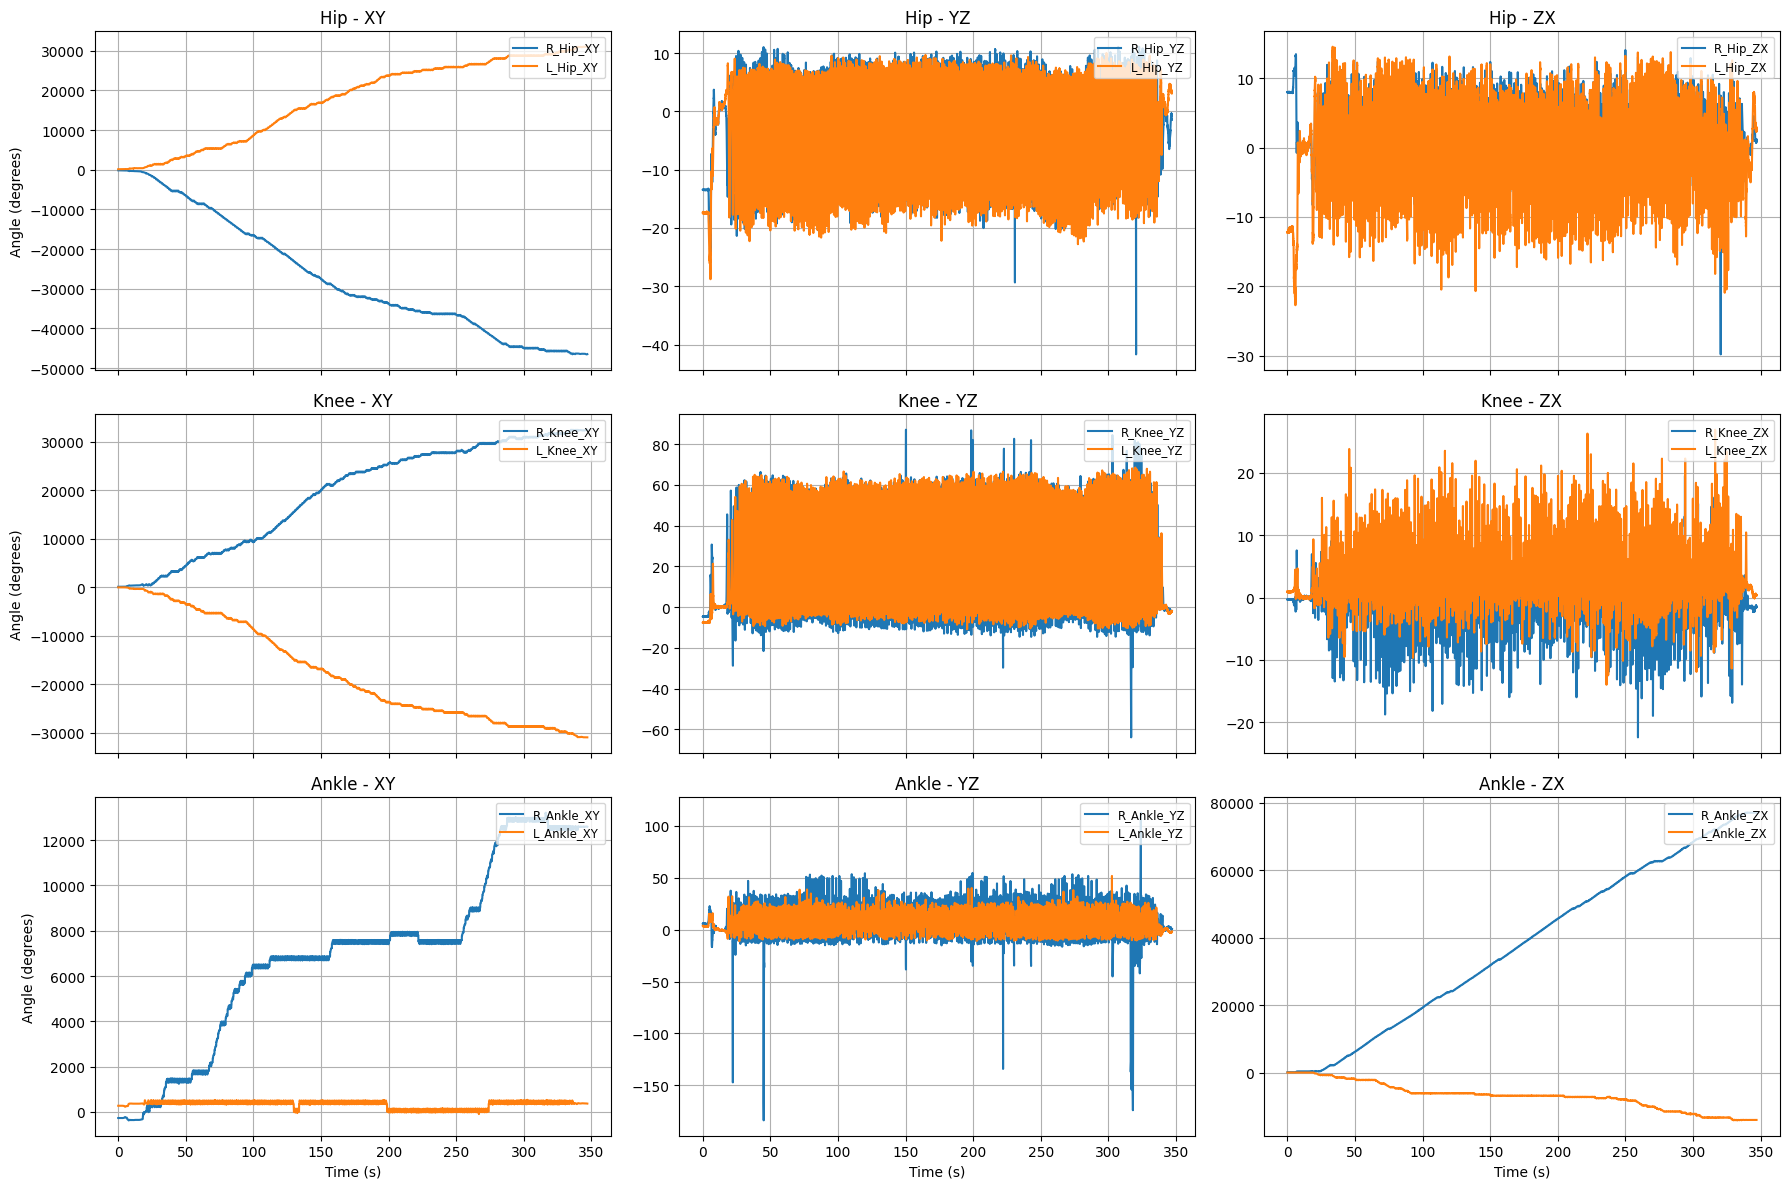

In [133]:
df_left = df_angles
time_left = df_left['Time']

# プロットしたい部位と軸の定義
target_joints = ["Hip", "Knee", "Ankle"]
planes = ["XY", "YZ", "ZX"]

# 3行3列のサブプロットを作成 (figsizeは適宜調整してください)
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 12), sharex=True)

# ループ処理で9個のグラフを描画
for i, joint in enumerate(target_joints):      # 行：部位 (Hip, Knee, Ankle)
    for j, plane in enumerate(planes):         # 列：軸 (XY, YZ, ZX)
        ax = axes[i, j]
        
        # 現在の部位と軸に該当するカラムを抽出 (例: "Hip"かつ"XY"が含まれるカラム → R_Hip_XY, L_Hip_XY)
        # カラム名が 'R_Hip_XY' のような形式であることを前提としています
        target_cols = [col for col in df_left.columns if (joint in col) and (plane in col)]
        
        for col in target_cols:
            ax.plot(time_left, df_left[col], label=col)
        
        # グラフの装飾
        ax.set_title(f'{joint} - {plane}')
        # ax.set_xlim(30, 32) 
        # ax.set_ylim(-1000, 1000)
        ax.grid(True)
        
        # 凡例はグラフごとに表示（必要に応じて調整）
        ax.legend(loc='upper right', fontsize='small')

        # 一番左の列だけY軸ラベルを表示
        if j == 0:
            ax.set_ylabel('Angle (degrees)')
        
        # 一番下の行だけX軸ラベルを表示
        if i == 2:
            ax.set_xlabel('Time (s)')

plt.tight_layout()
plt.show()

In [134]:
import numpy as np
import pandas as pd
from numpy import linalg as LA

# ============================================================
#  設定・定数定義（引用コードより統合）
# ============================================================
# 剛体ID定義に対応するインデックス (0-based for Python list/array)
R_ILIUM_INDEX               = 1
R_GREATER_TROCHANTER_INDEX  = 2
R_KNEE_INDEX                = 3
R_MALLEOLUS_INDEX           = 4
R_TOE_INDEX                 = 5
L_ILIUM_INDEX               = 6
L_GREATER_TROCHANTER_INDEX  = 7
L_KNEE_INDEX                = 8
L_MALLEOLUS_INDEX           = 9
L_TOE_INDEX                 = 10

# 計算する関節の数（右股，左股，右膝，左膝，右足首，左足首 の計6箇所）
JOINT_NO = 6

class CalculateAngle:
    """
    提供されたロジックに基づく角度計算クラス
    """
    @staticmethod
    def _vec(A, B, C):
        # ベクトル BA と BC を作成
        return np.stack((A - B, C - B), axis=0)

    @staticmethod
    def _angle2d(a, b):
        # 2Dでの角度計算
        inner = np.dot(a, b)
        norm  = LA.norm(a) * LA.norm(b)
        # ゼロ除算回避のための小さな値を加えるなどの処理が必要な場合がありますが
        # ここでは元のロジックを尊重してクリッピングのみ行います
        return np.degrees(np.arccos(np.clip(inner / norm, -1, 1)))

    def _angle3d(self, v):
        # XY, YZ, ZX 平面への投影角度を計算
        deg   = np.zeros(3)
        pairs = [
            (slice(None, 2),            0),  # xy plane (index 0, 1)
            (slice(1, None),            1),  # yz plane (index 1, 2)
            ((2, 0),                    2)   # zx plane (index 2, 0)
        ]
        
        for i, (sl, _) in enumerate(pairs):
            a = v[0][sl] if isinstance(sl, slice) else v[0][list(sl)]
            b = v[1][sl] if isinstance(sl, slice) else v[1][list(sl)]
            
            # 外積（2D cross product）を用いて符号（方向）を判定
            S = 0.5 * (b[0] * a[1] - b[1] * a[0])  
            ang = self._angle2d(a, b)
            deg[i] = 360 - ang if S < 0 else ang
        return deg

    def angles(self, pos):
        """
        pos: shape (10, 3) のマーカー座標配列
        return: shape (6, 3) の各関節角度 (XY, YZ, ZX)
        """
        # 座標変換: XYZ → XZY に入れ替え（YとZを交換）
        pos = pos[:, [0, 2, 1]].copy() 
        # X軸反転
        pos[:, 0] *= -1           
        
        out = np.zeros((JOINT_NO, 3))
    
        # インデックス定義 (0-basedに修正済み)
        idxs = [
            # 1. R-Hip (右股関節)
            (R_ILIUM_INDEX - 1, R_GREATER_TROCHANTER_INDEX - 1, R_KNEE_INDEX - 1),
            # 2. L-Hip (左股関節)
            (L_ILIUM_INDEX - 1, L_GREATER_TROCHANTER_INDEX - 1, L_KNEE_INDEX - 1),
            # 3. R-Knee (右膝関節)
            (R_GREATER_TROCHANTER_INDEX - 1, R_KNEE_INDEX - 1, R_MALLEOLUS_INDEX - 1),
            # 4. L-Knee (左膝関節)
            (L_GREATER_TROCHANTER_INDEX - 1, L_KNEE_INDEX - 1, L_MALLEOLUS_INDEX - 1),
            # 5. R-Ankle (右足首)
            (R_KNEE_INDEX - 1, R_MALLEOLUS_INDEX - 1, R_TOE_INDEX - 1),
            # 6. L-Ankle (左足首)
            (L_KNEE_INDEX - 1, L_MALLEOLUS_INDEX - 1, L_TOE_INDEX - 1),
        ]

        for i, (a, b, c) in enumerate(idxs):
            out[i] = self._angle3d(self._vec(pos[a], pos[b], pos[c]))
        return out

# ============================================================
#  メイン処理: DataFrameへの適用
# ============================================================

def process_mocap_data(df):
    calculator = CalculateAngle()
    
    # 全フレームの結果を格納するリスト
    all_angles = []
    
    # 剛体ID 001〜010 のカラム名を生成するヘルパー
    # 例: ['001_Position_X', '001_Position_Y', '001_Position_Z', '002_Position_X', ...]
    target_cols = []
    for i in range(1, 11):
        prefix = f"{i:03}" # 001, 002...
        target_cols.extend([f"{prefix}_Position_X", f"{prefix}_Position_Y", f"{prefix}_Position_Z"])
    
    # データをnumpy配列として抽出 (Frames, 30) -> (Frames, 10, 3)
    # これによりループ内でのデータアクセスを高速化します
    positions_flat = df[target_cols].values
    n_frames = positions_flat.shape[0]
    positions_3d = positions_flat.reshape(n_frames, 10, 3)
    
    # 各フレームごとに角度計算
    print("角度計算を開始します...")
    for frame_idx in range(n_frames):
        # 現在のフレームの座標 (10, 3)
        current_pos = positions_3d[frame_idx]
        
        # 角度計算実行
        angles = calculator.angles(current_pos) # shape (6, 3)
        
        # フラットにしてリストに追加 (1行分のデータ: 18要素)
        all_angles.append(angles.flatten())
    
    # 結果をDataFrameに変換
    # カラム名の定義
    joint_names = ["R_Hip", "L_Hip", "R_Knee", "L_Knee", "R_Ankle", "L_Ankle"]
    plane_names = ["XY", "YZ", "ZX"]
    columns = []
    for joint in joint_names:
        for plane in plane_names:
            columns.append(f"{joint}_{plane}")
            
    df_result = pd.DataFrame(all_angles, columns=columns)
    
    # 元のTime情報を結合（必要であれば）
    if 'Time (Seconds)' in df.columns:
        df_result.insert(0, 'Time', df['Time (Seconds)'])
    if 'Frame' in df.columns:
        df_result.insert(0, 'Frame', df['Frame'])
        
    return df_result

# 実行
# df_mocap が定義されている前提です
df_angles = process_mocap_data(df_mocap)

# 結果の確認
print("計算完了:")
print(df_angles.head())

角度計算を開始します...
計算完了:
   Frame   Time    R_Hip_XY    R_Hip_YZ    R_Hip_ZX    L_Hip_XY    L_Hip_YZ  \
0      0  0.000  148.648878  150.372376  172.257326  231.186452  128.820950   
1      1  0.004  148.635338  150.360598  172.247915  231.187817  128.831478   
2      2  0.008  148.591289  150.366887  172.304655  231.179647  128.825578   
3      3  0.012  148.647423  150.371976  172.255920  231.134509  128.898336   
4      4  0.016  148.597311  150.378366  172.314826  231.170186  128.844463   

     L_Hip_ZX   R_Knee_XY   R_Knee_YZ   R_Knee_ZX   L_Knee_XY   L_Knee_YZ  \
0  180.320967  192.304055  185.423100  178.718737  164.106407  184.498233   
1  180.307806  192.304154  185.436053  178.738929  164.130707  184.504947   
2  180.325141  192.181375  185.374270  178.742546  164.122945  184.497724   
3  180.326416  192.188829  185.372868  178.735734  164.133702  184.486599   
4  180.316990  192.186692  185.361705  178.720257  164.137579  184.504446   

    L_Knee_ZX  R_Ankle_XY  R_Ankle_YZ  R_A

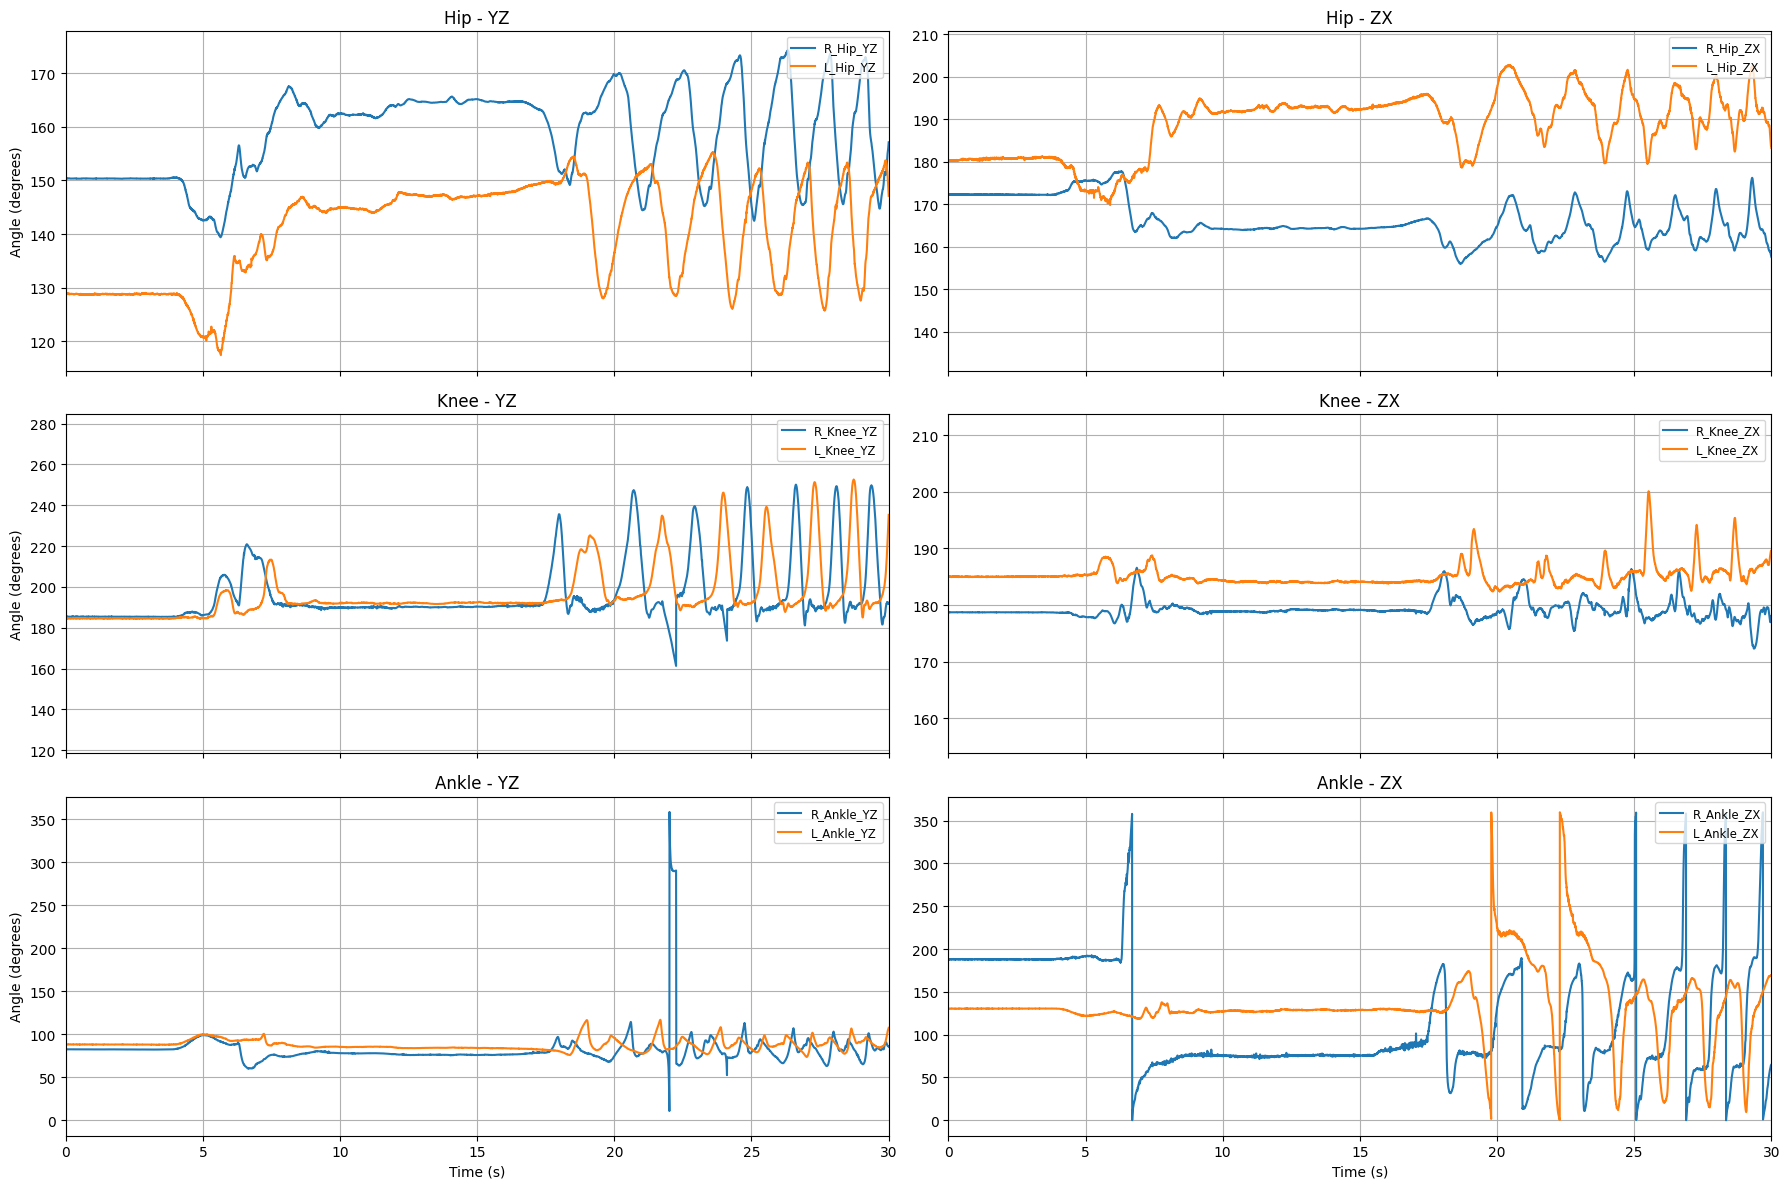

In [135]:
df_left = df_angles
time_left = df_left['Time']

# プロットしたい部位と軸の定義
target_joints = ["Hip", "Knee", "Ankle"]
planes = ["YZ", "ZX"]

# 3行2列のサブプロットを作成 (figsizeは適宜調整してください)
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18, 12), sharex=True)

# ループ処理で9個のグラフを描画
for i, joint in enumerate(target_joints):      # 行：部位 (Hip, Knee, Ankle)
    for j, plane in enumerate(planes):         # 列：軸 (XY, YZ, ZX)
        ax = axes[i, j]
        
        # 現在の部位と軸に該当するカラムを抽出 (例: "Hip"かつ"XY"が含まれるカラム → R_Hip_XY, L_Hip_XY)
        # カラム名が 'R_Hip_XY' のような形式であることを前提としています
        target_cols = [col for col in df_left.columns if (joint in col) and (plane in col)]
        
        for col in target_cols:
            ax.plot(time_left, df_left[col], label=col)
        
        # グラフの装飾
        ax.set_title(f'{joint} - {plane}')
        ax.set_xlim(0, 30) 
        # ax.set_ylim(-1000, 1000)
        ax.grid(True)
        
        # 凡例はグラフごとに表示（必要に応じて調整）
        ax.legend(loc='upper right', fontsize='small')

        # 一番左の列だけY軸ラベルを表示
        if j == 0:
            ax.set_ylabel('Angle (degrees)')
        
        # 一番下の行だけX軸ラベルを表示
        if i == 2:
            ax.set_xlabel('Time (s)')

plt.tight_layout()
plt.show()

[Left Foot] Target Window: 30.06s - 330.06s
  > Detected 233 steps.


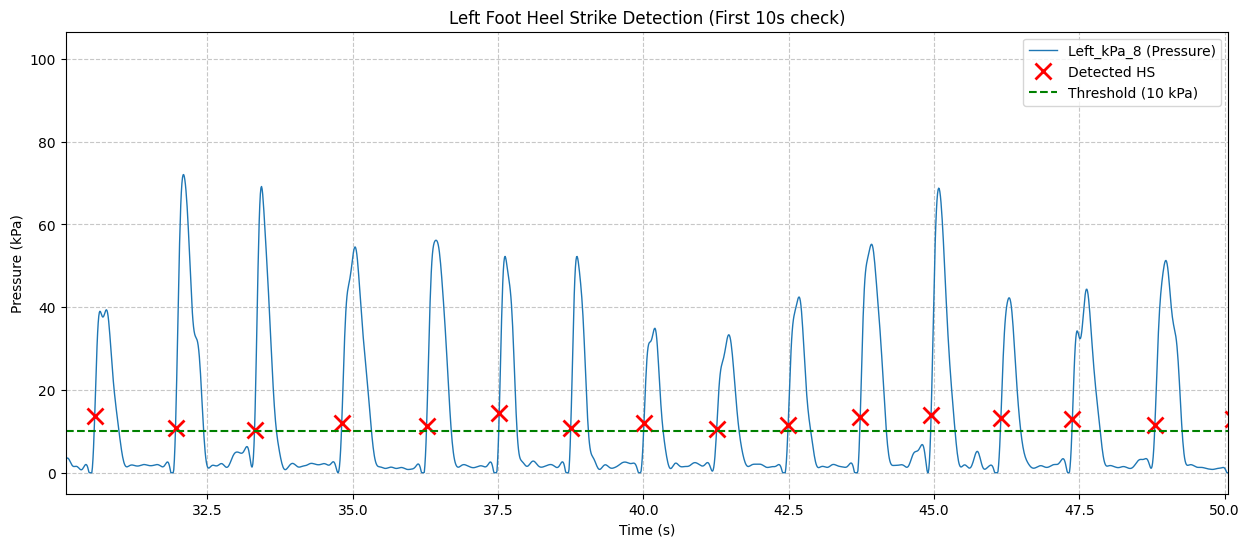

[Right Foot] Target Window: 30.07s - 330.07s
  > Detected 233 steps.


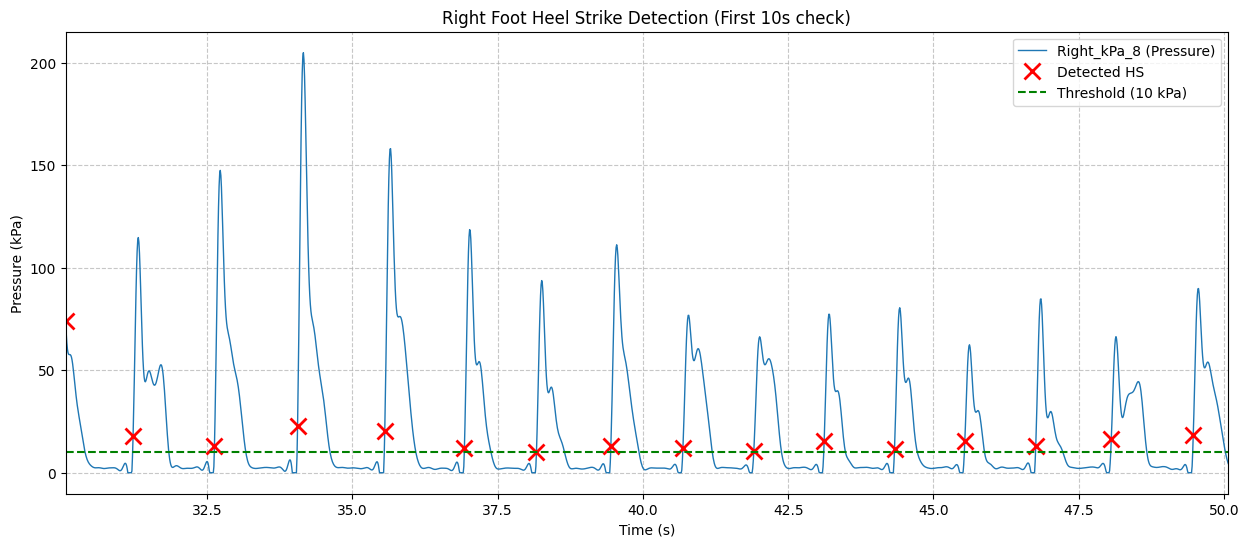

In [136]:
def detect_heel_strikes(signal_array, threshold=10, min_dist_samples=40):
    """
    踵接地 (HS) のタイミング（インデックス）を検出する関数
    
    Parameters:
    - signal_array: 踵の圧力データの配列 (numpy array)
    - threshold: 接地とみなす閾値 (kPa)。ノイズより大きく設定。
    - min_dist_samples: 次の接地までの最小サンプル数 (不応期)。
                        100Hzで0.4秒なら40サンプル。
    
    Returns:
    - indices: 接地開始タイミングのインデックス配列
    """
    # 閾値を超えている場所をTrue, それ以外をFalseにする
    is_contact = signal_array > threshold
    
    # False(浮いている) -> True(着いた) に切り替わる瞬間を検出 (立ち上がりエッジ)
    # diffをとると、立ち上がりは 1 (True), 立ち下がりは -1, 変化なしは 0
    # prepend=False で配列サイズを合わせる
    rising_edge = np.diff(is_contact.astype(int), prepend=0) == 1
    
    # 候補となるインデックスを取得
    potential_indices = np.where(rising_edge)[0]
    
    if len(potential_indices) == 0:
        return np.array([])

    # --- 不応期（チャタリング除去）処理 ---
    # 直前の検出から min_dist_samples 以内の検出は無視する
    true_indices = [potential_indices[0]]
    
    for idx in potential_indices[1:]:
        if idx - true_indices[-1] > min_dist_samples:
            true_indices.append(idx)
            
    return np.array(true_indices)

def slice_strides(df_target, split_indices):
    """
    インデックスに基づいてデータフレームを分割し、リストに格納する関数
    
    Parameters:
    - df_target: 分割したいデータフレーム (Zスコア化済みデータなど)
    - split_indices: 接地点のインデックス配列
    
    Returns:
    - stride_list: 分割されたデータフレームのリスト
    """
    strides = []
    
    # インデックス間のデータを切り出す
    # 例: idx[0]〜idx[1], idx[1]〜idx[2], ...
    for i in range(len(split_indices) - 1):
        start_idx = split_indices[i]
        end_idx = split_indices[i+1]
        
        # スライス (コピーを作成しておく)
        stride_df = df_target.iloc[start_idx:end_idx].copy()
        
        # 1ストライドの時間軸を0からスタートするようにリセットする場合
        # stride_df['Time (Seconds)'] = stride_df['Time (Seconds)'] - stride_df['Time (Seconds)'].iloc[0]
        
        strides.append(stride_df)
        
    return strides

def extract_strides_in_window(df_smooth, df_z, heel_col, duration=300, threshold=10, min_dist_sec=0.6, fs=100, show_plot=True, title_prefix=""):
    """
    Marker開始から300秒間を切り出し、ストライド分割を行う関数 (プロット機能付き)

    Parameters:
    - df_smooth: 接地検出用のデータ (平滑化済み, kPa単位)
    - df_z:     出力用のデータ (Zスコア化済み)
    - heel_col: 踵の圧力カラム名
    - duration: 切り出す期間 (秒)
    
    Returns:
    - stride_list: 分割された1歩ごとのDataFrameリスト (Zスコア化データ)

    """
    
    # 1. マーカー開始時刻の特定
    marker_cols = [c for c in df_smooth.columns if 'Marker' in c]
    if not marker_cols:
        print("Error: No marker column found.")
        return []
    
    valid_markers = df_smooth[['Time (Seconds)'] + marker_cols].dropna(subset=marker_cols, how='all')
    if valid_markers.empty:
        print("Error: Marker never appears.")
        return []
        
    start_time = valid_markers.iloc[1]['Time (Seconds)']
    end_time = start_time + duration
    
    print(f"[{title_prefix}] Target Window: {start_time:.2f}s - {end_time:.2f}s")
    
    # 2. 300秒間だけデータを切り出す
    mask = (df_smooth['Time (Seconds)'] >= start_time) & (df_smooth['Time (Seconds)'] <= end_time)
    
    # indexをリセット (0行目 = 切り出し開始地点)
    df_crop_smooth = df_smooth.loc[mask].reset_index(drop=True)
    df_crop_z      = df_z.loc[mask].reset_index(drop=True)
    
    if df_crop_smooth.empty:
        print("Warning: Cropped dataframe is empty.")
        return []

    # 3. 接地タイミングを検出
    heel_signal = df_crop_smooth[heel_col].values
    min_dist_samples = int(min_dist_sec * fs)
    
    hs_indices = detect_heel_strikes(heel_signal, threshold=threshold, min_dist_samples=min_dist_samples)
    print(f"  > Detected {len(hs_indices)} steps.")
    
    # --- ★追加: 確認用プロット ---
    if show_plot and len(hs_indices) > 0:
        plt.figure(figsize=(15, 6))
        
        # 踵の圧力波形
        time_axis = df_crop_smooth['Time (Seconds)']
        # 切り出し後の相対時間にするなら以下を有効化
        # time_axis = time_axis - time_axis.iloc[0] 
        
        plt.plot(time_axis, heel_signal, label=f'{heel_col} (Pressure)', color='tab:blue', linewidth=1)
        
        # 検出ポイントを赤×でプロット
        plt.plot(time_axis.iloc[hs_indices], 
                 heel_signal[hs_indices], 
                 'rx', markersize=12, markeredgewidth=2, label='Detected HS')
        
        # 閾値ライン
        plt.axhline(y=threshold, color='green', linestyle='--', label=f'Threshold ({threshold} kPa)')
        
        plt.title(f"{title_prefix} Heel Strike Detection (First 10s check)")
        plt.xlabel("Time (s)")
        plt.ylabel("Pressure (kPa)")
        plt.legend(loc='upper right')
        
        # 見やすいように最初の10秒だけ拡大 (データがあれば)
        plot_start = time_axis.iloc[0]
        plot_end = min(time_axis.iloc[-1], plot_start + 20) # 最初の10秒、あるいはデータの終わりまで
        plt.xlim(plot_start, plot_end)
        
        plt.grid(True, which='both', linestyle='--', alpha=0.7)
        plt.show()

    # 4. 分割
    stride_list = slice_strides(df_crop_z, hs_indices)
    
    return stride_list

# ==========================================
# 実行 (プロットが表示されます)
# ==========================================

LEFT_HEEL_COL = 'Left_kPa_8'   
RIGHT_HEEL_COL = 'Right_kPa_8'

# 左足の処理と確認
left_strides = extract_strides_in_window(
    df_smooth=df_left_smoothed, 
    df_z=df_left_z, 
    heel_col=LEFT_HEEL_COL,
    show_plot=True,         # ★これでグラフが出ます
    title_prefix="Left Foot"
)

# 右足の処理と確認
right_strides = extract_strides_in_window(
    df_smooth=df_right_smoothed, 
    df_z=df_right_z, 
    heel_col=RIGHT_HEEL_COL,
    show_plot=True,         # ★これでグラフが出ます
    title_prefix="Right Foot"
)

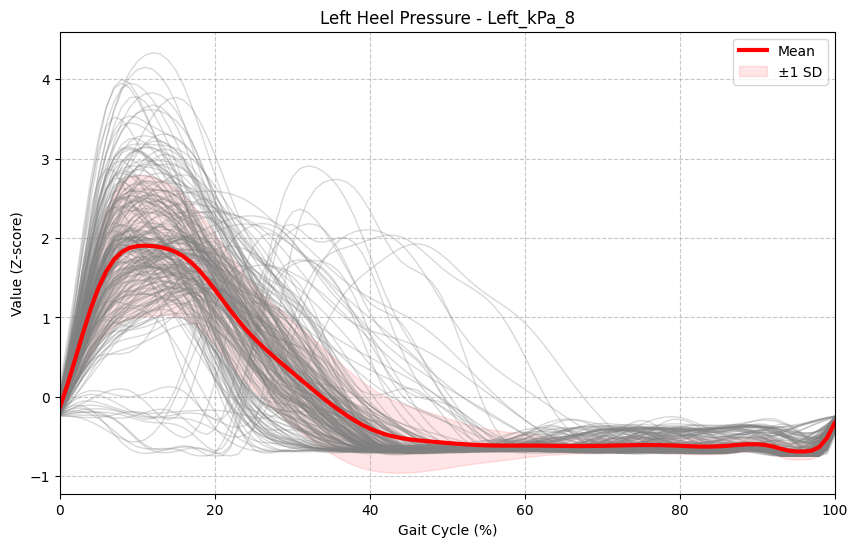

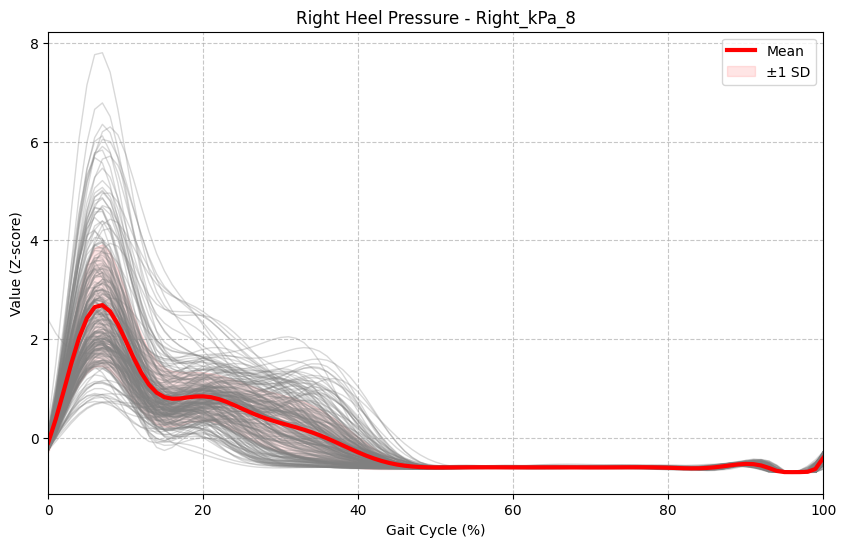

In [137]:
def plot_ensemble_strides(stride_list, target_col, title="Stride Ensemble", unit="Z-score"):
    """
    複数のストライドデータを0-100%に正規化して重ね書きする関数
    
    Parameters:
    - stride_list: 切り出されたDataFrameのリスト
    - target_col: プロットしたいカラム名 (例: 'Right_kPa_1' や 'Acc_X')
    - title: グラフのタイトル
    - unit: Y軸の単位ラベル
    """
    if not stride_list:
        print("No strides to plot.")
        return

    # 正規化後のデータ点数 (0% ~ 100% を 101分割)
    norm_length = 101
    x_norm = np.linspace(0, 100, norm_length)
    
    # データを蓄積するリスト
    ensemble_data = []

    plt.figure(figsize=(10, 6))

    # --- 1. 個別のストライドをプロット ---
    for df in stride_list:
        # 対象カラムのデータを取得
        y_values = df[target_col].values
        
        # データの長さが足りない場合はスキップ（念のため）
        if len(y_values) < 2:
            continue

        # 時間軸の正規化 (線形補間を使ってデータ点数をnorm_lengthに揃える)
        # 元の配列のインデックスを 0~100 にマッピング
        x_original = np.linspace(0, 100, len(y_values))
        y_interp = np.interp(x_norm, x_original, y_values)
        
        ensemble_data.append(y_interp)

        # 薄いグレーでプロット
        plt.plot(x_norm, y_interp, color='gray', alpha=0.3, linewidth=1)

    # --- 2. 平均波形の計算とプロット ---
    if ensemble_data:
        # numpy配列に変換 (行: ストライド数, 列: 101)
        ensemble_matrix = np.array(ensemble_data)
        
        # 平均と標準偏差を計算
        mean_waveform = np.mean(ensemble_matrix, axis=0)
        std_waveform = np.std(ensemble_matrix, axis=0)
        
        # 平均値を赤色でプロット
        plt.plot(x_norm, mean_waveform, color='red', linewidth=3, label='Mean')
        
        # (オプション) 標準偏差の範囲を塗りつぶし
        plt.fill_between(x_norm, 
                         mean_waveform - std_waveform, 
                         mean_waveform + std_waveform, 
                         color='red', alpha=0.1, label='±1 SD')

    # --- 3. グラフの装飾 ---
    plt.title(f"{title} - {target_col}")
    plt.xlabel("Gait Cycle (%)")
    plt.ylabel(f"Value ({unit})")
    plt.xlim(0, 100)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.show()

# ==========================================
# 実行例
# ==========================================
plot_ensemble_strides(
    stride_list=left_strides, 
    target_col='Left_kPa_8', 
    title="Left Heel Pressure",
    unit="Z-score"
)
plot_ensemble_strides(
    stride_list=right_strides, 
    target_col='Right_kPa_8', 
    title="Right Heel Pressure",
    unit="Z-score"
)

左足マーカー数: 2
[3.7, 30.06]
右足マーカー数: 2
[3.69, 30.07]


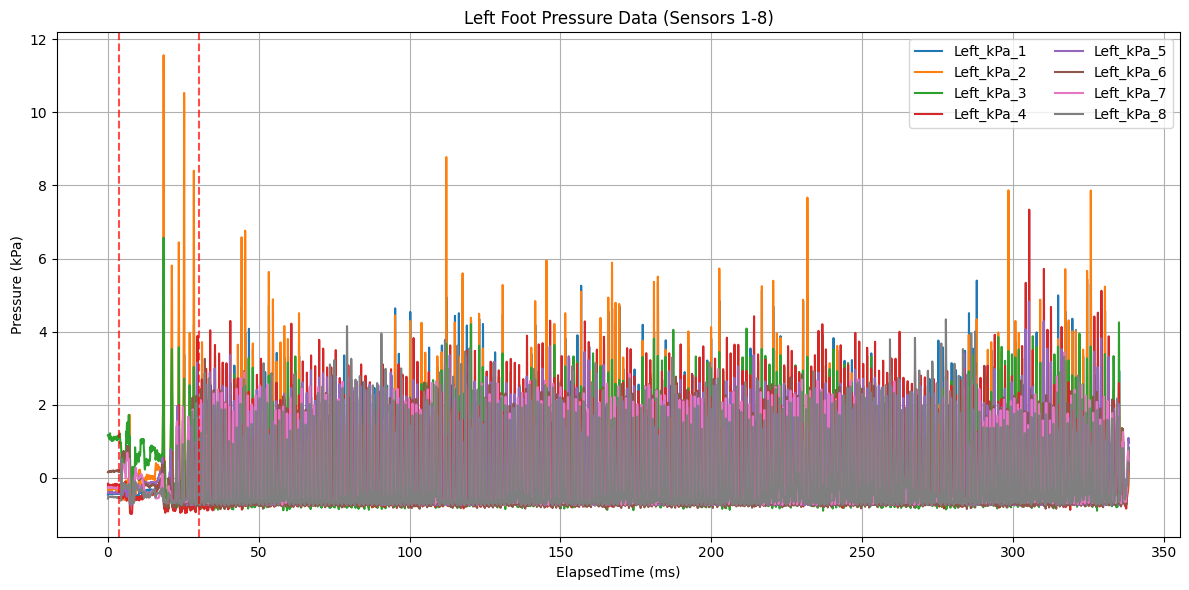

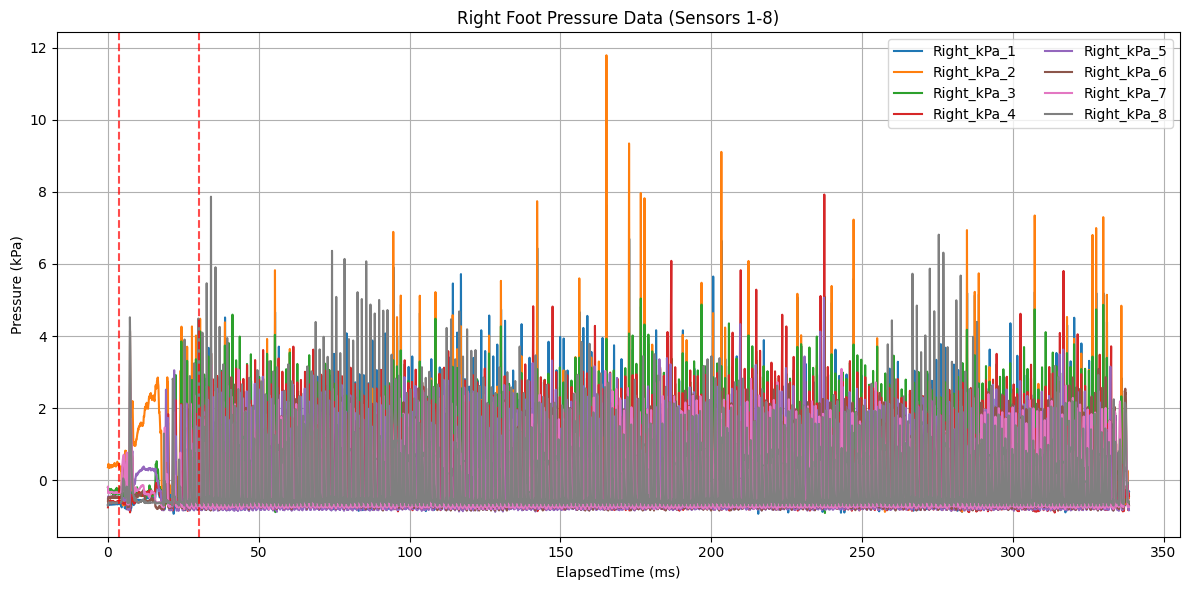

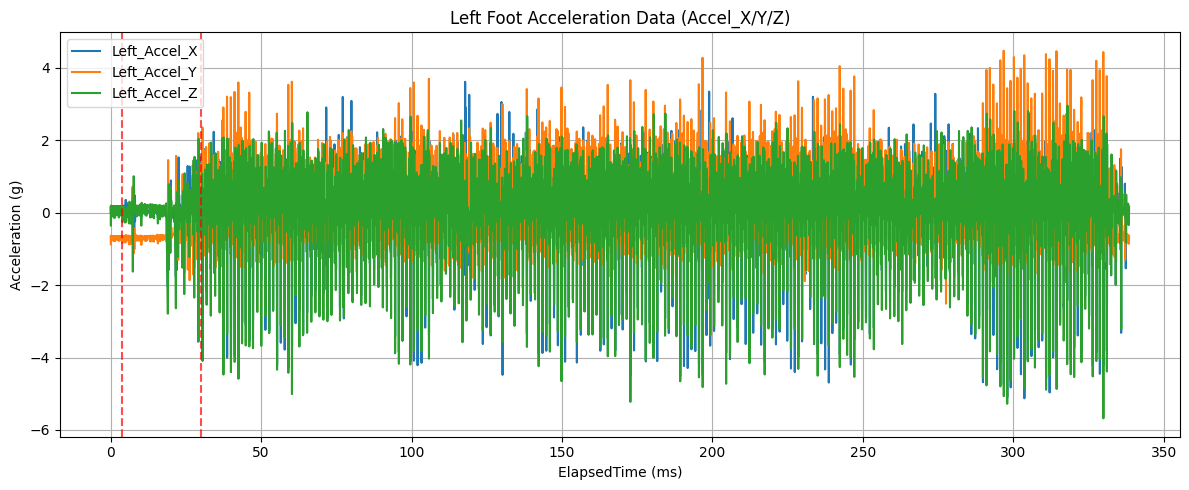

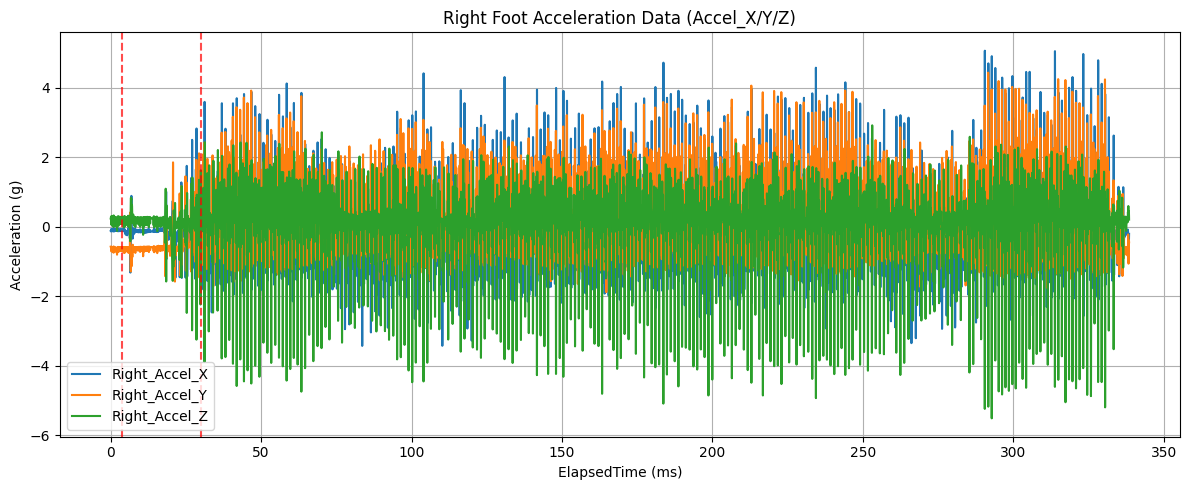

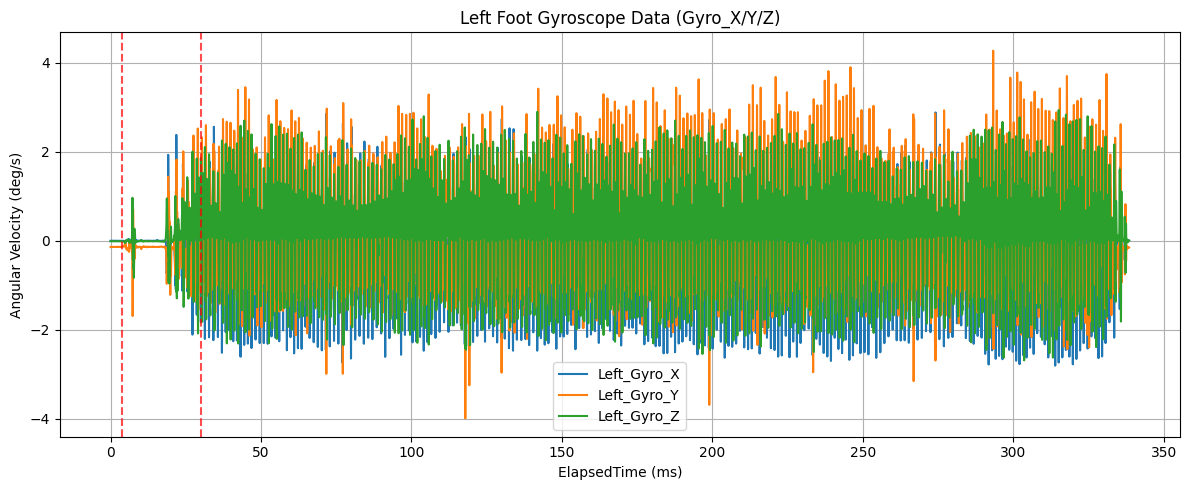

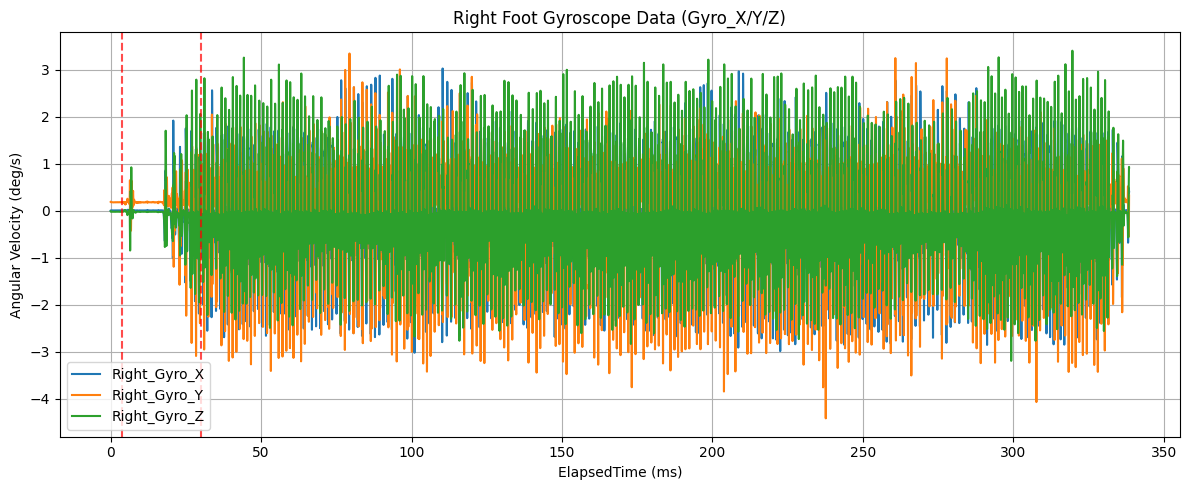

In [138]:
df_left = df_left_z
df_right = df_right_z

# 横軸：ElapsedTime
time_left = df_left['Time (Seconds)']
time_right = df_right['Time (Seconds)']

# マーカーが記録されている時刻を取得（0でない，かつNaNでない行）
marker_times_left = df_left[(df_left['Marker'].notna()) & (df_left['Marker'] != 0)]['Time (Seconds)']
marker_times_right = df_right[(df_right['Marker'].notna()) & (df_right['Marker'] != 0)]['Time (Seconds)']
print(f"左足マーカー数: {len(marker_times_left)}")
print(marker_times_left.tolist())
print(f"右足マーカー数: {len(marker_times_right)}")
print(marker_times_right.tolist())



# 1. 足圧センサーデータ（kPa_1～8）- 左足
kpa_cols = ['kPa_1', 'kPa_2', 'kPa_3', 'kPa_4', 'kPa_5', 'kPa_6', 'kPa_7', 'kPa_8']
plt.figure(figsize=(12, 6))
for col in kpa_cols:
    plt.plot(time_left, df_left[f'Left_{col}'], label=f'Left_{col}')
for t in marker_times_left:
    plt.axvline(x=t, color='red', linestyle='--', alpha=0.7, linewidth=1.5)
plt.xlabel('ElapsedTime (ms)')
# plt.xlim(40000,50000)
plt.ylabel('Pressure (kPa)')
plt.title('Left Foot Pressure Data (Sensors 1-8)')
plt.legend(loc='best', ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()

# 1. 足圧センサーデータ（kPa_1～8）- 右足
plt.figure(figsize=(12, 6))
for col in kpa_cols:
    plt.plot(time_right, df_right[f'Right_{col}'], label=f'Right_{col}')
for t in marker_times_right:
    plt.axvline(x=t, color='red', linestyle='--', alpha=0.7, linewidth=1.5)
plt.xlabel('ElapsedTime (ms)')
# plt.xlim(40000,50000)
plt.ylabel('Pressure (kPa)')
plt.title('Right Foot Pressure Data (Sensors 1-8)')
plt.legend(loc='best', ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. 加速度データ - 左足
accel_cols = ['Accel_X', 'Accel_Y', 'Accel_Z']

plt.figure(figsize=(12, 5))
for col in accel_cols:
    plt.plot(time_left, df_left[f'Left_{col}'], label=f'Left_{col}')
for t in marker_times_left:
    plt.axvline(x=t, color='red', linestyle='--', alpha=0.7, linewidth=1.5)
plt.xlabel('ElapsedTime (ms)')
plt.ylabel('Acceleration (g)')
plt.title('Left Foot Acceleration Data (Accel_X/Y/Z)')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. 加速度データ - 右足
plt.figure(figsize=(12, 5))
for col in accel_cols:
    plt.plot(time_right, df_right[f'Right_{col}'], label=f'Right_{col}')
for t in marker_times_right:
    plt.axvline(x=t, color='red', linestyle='--', alpha=0.7, linewidth=1.5)
plt.xlabel('ElapsedTime (ms)')
plt.ylabel('Acceleration (g)')
plt.title('Right Foot Acceleration Data (Accel_X/Y/Z)')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. 角速度データ - 左足
gyro_cols = ['Gyro_X', 'Gyro_Y', 'Gyro_Z']

plt.figure(figsize=(12, 5))
for col in gyro_cols:
    plt.plot(time_left, df_left[f'Left_{col}'], label=f'Left_{col}')
for t in marker_times_left:
    plt.axvline(x=t, color='red', linestyle='--', alpha=0.7, linewidth=1.5)
plt.xlabel('ElapsedTime (ms)')
plt.ylabel('Angular Velocity (deg/s)')
plt.title('Left Foot Gyroscope Data (Gyro_X/Y/Z)')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. 角速度データ - 右足
plt.figure(figsize=(12, 5))
for col in gyro_cols:
    plt.plot(time_right, df_right[f'Right_{col}'], label=f'Right_{col}')
for t in marker_times_right:
    plt.axvline(x=t, color='red', linestyle='--', alpha=0.7, linewidth=1.5)
plt.xlabel('ElapsedTime (ms)')
plt.ylabel('Angular Velocity (deg/s)')
plt.title('Right Foot Gyroscope Data (Gyro_X/Y/Z)')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()